In [275]:
import pandas as pd
import os
import numpy as np
from scipy.stats import rankdata

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

SEED = 2020

def seed_everything(SEED):
    np.random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)

seed_everything(SEED)

In [276]:
train_df = pd.read_csv('../../TRIPLE S3FOLD/TSKFold_train.csv')
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,patient_code
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,1
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,2
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,3
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,4


In [277]:
FOLDS = 5

skf = KFold(n_splits=FOLDS,shuffle=True,random_state=SEED)

for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):
    print(f"#### FOLD: {fold}")
    print(f"#### Train idx: {idxT}")
    print(f"#### Train idx: {idxV}\n")

#### FOLD: 0
#### Train idx: [ 0  3  4  5  6  7  8 10 11 12 13 14]
#### Train idx: [1 2 9]

#### FOLD: 1
#### Train idx: [ 0  1  2  3  5  6  7  8  9 10 12 14]
#### Train idx: [ 4 11 13]

#### FOLD: 2
#### Train idx: [ 0  1  2  3  4  6  8  9 10 11 12 13]
#### Train idx: [ 5  7 14]

#### FOLD: 3
#### Train idx: [ 0  1  2  3  4  5  7  8  9 11 13 14]
#### Train idx: [ 6 10 12]

#### FOLD: 4
#### Train idx: [ 1  2  4  5  6  7  9 10 11 12 13 14]
#### Train idx: [0 3 8]



In [4]:
models = [
#     'B0 128',
#     'B1 192',
#     'B1 256',
#     'B4 128',
#     'B4 192',
#     'B4 256',
#     'B4 384',
#     'B5 128',
#     'B5 192',
#     'B5 256',
#     'B5 384',
#     'B6 128',
#     'B6 192',
#     'B6 256',
#     'B6 384',
#     'BS32/B0 128',
#     'BS32/B0 192',
#     'BS32/B0 256',
#     'BS32/B3 128',
#     'BS32/B3 192',
#     'BS32/B4 512',
#     'BS32/B5 384',
#     'BS32/B5 512',
#     'BS32/B6 512',
#     'BS32/FocalLoss/B0 128',
#     'BS32/FocalLoss/B0 192',
#     'BS32/FocalLoss/B0 256',
#     'BS32/FocalLoss/B0 384',
#     'BS32/FocalLoss/B3 256',
#     'BS32/FocalLoss/B3 384',
    'BS32/FocalLoss/B4 192',
    'BS32/FocalLoss/B4 256',
    'BS32/FocalLoss/B4 384',
    'BS32/FocalLoss/B4 512',
    'BS32/FocalLoss/B4 768',
    'BS32/FocalLoss/B5 192',
    'BS32/FocalLoss/B5 256',
    'BS32/FocalLoss/B5 384',
    'BS32/FocalLoss/B5 512',
    'BS32/FocalLoss/B5 768',
    'BS32/FocalLoss/B6 128',
    'BS32/FocalLoss/B6 192',
    'BS32/FocalLoss/B6 256',
    'BS32/FocalLoss/B6 384',
    'BS32/FocalLoss/B6 512',
    'BS32/FocalLoss/B7 128',
    'BS32/FocalLoss/B7 192',
    'BS32/FocalLoss/B7 256',
    'BS32/FocalLoss/B7 384',
    'BS32/FocalLoss/B7 512',
]

In [5]:
print(f"#### Model: {models[0]}")
alloof = pd.read_csv([models[0]+'/'+filename for filename in os.listdir(models[0]) if 'oof_' in filename][0])
alloofrank = pd.read_csv([models[0]+'/'+filename for filename in os.listdir(models[0]) if 'oofrank_' in filename][0])
alltestmean = pd.read_csv([models[0]+'/'+filename for filename in os.listdir(models[0]) if 'TESTPREDS_MEAN' in filename][0])
alltestrank = pd.read_csv([models[0]+'/'+filename for filename in os.listdir(models[0]) if 'TESTPREDS_RANK' in filename][0])

for i, model in enumerate(models[1:]):
    print(f"#### Model: {model}")
    oof = pd.read_csv([model+'/'+filename for filename in os.listdir(model) if 'oof_' in filename][0])[['image_name','pred']]
    oofrank = pd.read_csv([model+'/'+filename for filename in os.listdir(model) if 'oofrank_' in filename][0])[['image_name','pred']]
    testmean = pd.read_csv([model+'/'+filename for filename in os.listdir(model) if 'TESTPREDS_MEAN' in filename][0])
    testrank = pd.read_csv([model+'/'+filename for filename in os.listdir(model) if 'TESTPREDS_RANK' in filename][0])
    
    alloof = alloof.merge(oof,on='image_name',suffixes=(f'_{i}', f'_{i+1}'))
    alloofrank = alloofrank.merge(oofrank,on='image_name',suffixes=(f'_{i}', f'_{i+1}'))
    alltestmean = alltestmean.merge(testmean,on='image_name',suffixes=(f'_{i}', f'_{i+1}'))
    alltestrank = alltestrank.merge(testrank,on='image_name',suffixes=(f'_{i}', f'_{i+1}'))

#### Model: BS32/FocalLoss/B4 192
#### Model: BS32/FocalLoss/B4 256
#### Model: BS32/FocalLoss/B4 384
#### Model: BS32/FocalLoss/B4 512
#### Model: BS32/FocalLoss/B4 768
#### Model: BS32/FocalLoss/B5 192
#### Model: BS32/FocalLoss/B5 256
#### Model: BS32/FocalLoss/B5 384
#### Model: BS32/FocalLoss/B5 512
#### Model: BS32/FocalLoss/B5 768
#### Model: BS32/FocalLoss/B6 128
#### Model: BS32/FocalLoss/B6 192
#### Model: BS32/FocalLoss/B6 256
#### Model: BS32/FocalLoss/B6 384
#### Model: BS32/FocalLoss/B6 512
#### Model: BS32/FocalLoss/B7 128
#### Model: BS32/FocalLoss/B7 192
#### Model: BS32/FocalLoss/B7 256
#### Model: BS32/FocalLoss/B7 384
#### Model: BS32/FocalLoss/B7 512


In [6]:
alloof.head()

,image_name,pred_0,target,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,...,pred_10,pred_11,pred_12,pred_13,pred_14,pred_15,pred_16,pred_17,pred_18,pred_19
0,ISIC_0074311,0.027380,0,0.007072,0.017246,0.013754,0.031849,0.021575,0.039669,0.022537,...,0.028024,0.061708,0.019556,0.014420,0.010695,0.033743,0.022342,0.023057,0.024819,0.014361
1,ISIC_0088137,0.021910,0,0.016291,0.018847,0.005131,0.005158,0.011272,0.025649,0.004653,...,0.039448,0.018969,0.015011,0.019723,0.001965,0.021958,0.006130,0.007602,0.014498,0.002633
2,ISIC_0076262,0.072156,0,0.036528,0.014745,0.023905,0.012715,0.032917,0.017270,0.006613,...,0.042531,0.033486,0.030268,0.024172,0.024909,0.038222,0.062870,0.037537,0.055748,0.034973
3,ISIC_0081956,0.008172,0,0.001637,0.004259,0.002139,0.001102,0.021527,0.009917,0.004789,...,0.007363,0.006491,0.005100,0.008408,0.001846,0.012945,0.003197,0.003613,0.001693,0.006747
4,ISIC_0091996,0.306020,0,0.116592,0.173594,0.136268,0.113232,0.102232,0.096842,0.120057,...,0.196039,0.176601,0.203089,0.183114,0.233772,0.183183,0.323093,0.226814,0.171925,0.081695


In [7]:
alltestmean.head()

,image_name,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,...,target_10,target_11,target_12,target_13,target_14,target_15,target_16,target_17,target_18,target_19
0,ISIC_0052060,0.006521,0.006102,0.006504,0.009082,0.001462,0.007953,0.011682,0.006616,0.007827,...,0.019197,0.011698,0.004224,0.009958,0.003279,0.015603,0.009248,0.008274,0.009691,0.005934
1,ISIC_0052349,0.012417,0.010117,0.006046,0.009182,0.006312,0.007708,0.008067,0.004869,0.006961,...,0.011379,0.011162,0.013745,0.006155,0.000905,0.014770,0.005620,0.006108,0.009886,0.004191
2,ISIC_0058510,0.005425,0.005616,0.006794,0.005066,0.007779,0.005612,0.007360,0.008964,0.005375,...,0.009568,0.006150,0.007375,0.007837,0.005600,0.006484,0.005241,0.002869,0.004744,0.008714
3,ISIC_0073313,0.007595,0.006651,0.005836,0.007402,0.006286,0.009066,0.009553,0.010566,0.012416,...,0.005941,0.004676,0.009332,0.009908,0.004608,0.004795,0.003517,0.003176,0.005848,0.005090
4,ISIC_0073502,0.023867,0.024016,0.041773,0.049930,0.046472,0.034076,0.037527,0.022982,0.033563,...,0.118364,0.073155,0.017838,0.021254,0.020724,0.069776,0.053319,0.034225,0.037457,0.025357


In [8]:
oof = train_df[['image_name','tfrecord']].merge(alloof,on='image_name')
oofrank = train_df[['image_name','tfrecord']].merge(alloofrank,on='image_name')

oof.head()

,image_name,tfrecord,pred_0,target,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,...,pred_10,pred_11,pred_12,pred_13,pred_14,pred_15,pred_16,pred_17,pred_18,pred_19
0,ISIC_2637011,0,0.098901,0,0.107084,0.238284,0.192832,0.114834,0.098217,0.060451,...,0.256507,0.152184,0.016087,0.040035,0.040109,0.133250,0.161742,0.048024,0.048147,0.071055
1,ISIC_0015719,0,0.009303,0,0.001332,0.002475,0.007418,0.003829,0.003846,0.001222,...,0.008519,0.003621,0.017128,0.001345,0.000659,0.016242,0.006524,0.001123,0.004042,0.006944
2,ISIC_0052212,6,0.012873,0,0.005466,0.001788,0.002433,0.006369,0.014579,0.025643,...,0.042909,0.059880,0.012702,0.006284,0.001556,0.027325,0.026849,0.022393,0.000161,0.006859
3,ISIC_0068279,0,0.069369,0,0.029168,0.051117,0.079939,0.095149,0.049010,0.019033,...,0.102188,0.174034,0.093437,0.097888,0.058416,0.043626,0.035305,0.080494,0.047398,0.023843
4,ISIC_0074268,11,0.001915,0,0.003066,0.000568,0.005409,0.000699,0.002353,0.001215,...,0.015025,0.012895,0.004719,0.008354,0.001710,0.016194,0.006745,0.006071,0.004783,0.001676


In [9]:
best_auc = 0

## OOF

In [16]:
FOLDS = 5

skf = KFold(n_splits=FOLDS,shuffle=True,random_state=SEED)

cvScore = []
valpreds = []
valimagenames = []
valtargets = []

for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):
    print(f"#### FOLD: {fold}")
    print(f"#### Train idx: {idxT}")
    print(f"#### Train idx: {idxV}\n")
    
    X_train, y_train = oof[oof.tfrecord.isin(idxT)][[column for column in oof.columns if 'pred' in column]], oof[oof.tfrecord.isin(idxT)].target
    X_val, y_val = oof[oof.tfrecord.isin(idxV)][[column for column in oof.columns if 'pred' in column]], oof[oof.tfrecord.isin(idxV)].target
    
#     clf = LogisticRegression(penalty='l2',
#                              dual=False,
#                              tol=0.0001,
#                              C=1e-6,
#                              fit_intercept=False,
#                              intercept_scaling=1,
#                              class_weight=None,
#                              random_state=SEED,
#                              solver='lbfgs',
#                              max_iter=50,
#                              multi_class='auto',
#                              verbose=0,
#                              warm_start=False, 
#                              n_jobs=-1,
#                              l1_ratio=None)
    
    clf = RandomForestClassifier(
                                n_estimators=100,
                                criterion='gini',
                                max_depth=5,
                                min_samples_split=5,
                                min_samples_leaf=1,
                                min_weight_fraction_leaf=0.01,
                                max_features='auto',
                                max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None,
                                bootstrap=True,
                                oob_score=False,
                                n_jobs=-1,
                                random_state=SEED,
                                verbose=0,
                                warm_start=False,
                                class_weight=None,
                                ccp_alpha=0.0,
                                max_samples=None)
    
    clf.fit(X_train,y_train)
    
#     print("#### Coef: ",clf.coef_)
    print("#### Train AUC: ",roc_auc_score(y_train,clf.predict_proba(X_train)[:,1]))
    
    pred = clf.predict_proba(X_val)[:,1]
    valpreds.append(pred)
    valimagenames.append(oof[oof.tfrecord.isin(idxV)].image_name.values)
    valtargets.append(y_val)
    
    valauc = roc_auc_score(y_val,pred)
    cvScore.append(valauc)
    print("#### Val AUC: ",valauc)
    
    print()

valtargets = np.concatenate(valtargets)
valpreds = np.concatenate(valpreds)
auc = roc_auc_score(valtargets,valpreds)
print(f"#### CV: {auc}")

if best_auc<auc:
    print("Score improved!!")
    best_auc = auc
else:
    print("No improvement!!")
    print("Best AUC: ",best_auc)

#### FOLD: 0
#### Train idx: [ 0  3  4  5  6  7  8 10 11 12 13 14]
#### Train idx: [1 2 9]

#### Train AUC:  0.9557956071932556
#### Val AUC:  0.9544756639537374

#### FOLD: 1
#### Train idx: [ 0  1  2  3  5  6  7  8  9 10 12 14]
#### Train idx: [ 4 11 13]

#### Train AUC:  0.9588955502164512
#### Val AUC:  0.9379721686014938

#### FOLD: 2
#### Train idx: [ 0  1  2  3  4  6  8  9 10 11 12 13]
#### Train idx: [ 5  7 14]

#### Train AUC:  0.9555606304719171
#### Val AUC:  0.9544535966438146

#### FOLD: 3
#### Train idx: [ 0  1  2  3  4  5  7  8  9 11 13 14]
#### Train idx: [ 6 10 12]

#### Train AUC:  0.9584859143134694
#### Val AUC:  0.9424085383835838

#### FOLD: 4
#### Train idx: [ 1  2  4  5  6  7  9 10 11 12 13 14]
#### Train idx: [0 3 8]

#### Train AUC:  0.9565932066133009
#### Val AUC:  0.9538190120381901

#### CV: 0.9479598816304738
No improvement!!
Best AUC:  0.9479598816304738


## OOFRANK

In [17]:
FOLDS = 5

skf = KFold(n_splits=FOLDS,shuffle=True,random_state=SEED)

cvScore = []
valpreds = []
valimagenames = []
valtargets = []

for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):
    print(f"#### FOLD: {fold}")
    print(f"#### Train idx: {idxT}")
    print(f"#### Train idx: {idxV}\n")
    
    X_train, y_train = oofrank[oofrank.tfrecord.isin(idxT)][[column for column in oofrank.columns if 'pred' in column]], oofrank[oofrank.tfrecord.isin(idxT)].target
    X_val, y_val = oofrank[oofrank.tfrecord.isin(idxV)][[column for column in oofrank.columns if 'pred' in column]], oofrank[oofrank.tfrecord.isin(idxV)].target
    
#     clf = LogisticRegression(penalty='l2',
#                              dual=False,
#                              tol=0.0001,
#                              C=1e-2,
#                              fit_intercept=False,
#                              intercept_scaling=1,
#                              class_weight=None,
#                              random_state=SEED,
#                              solver='lbfgs',
#                              max_iter=50,
#                              multi_class='auto',
#                              verbose=0,
#                              warm_start=False, 
#                              n_jobs=-1,
#                              l1_ratio=None)
    
    clf = RandomForestClassifier(
                                n_estimators=100,
                                criterion='gini',
                                max_depth=5,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                min_weight_fraction_leaf=0.0,
                                max_features='auto',
                                max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None,
                                bootstrap=True,
                                oob_score=False,
                                n_jobs=-1,
                                random_state=SEED,
                                verbose=0,
                                warm_start=False,
                                class_weight=None,
                                ccp_alpha=0.0,
                                max_samples=None)
    
    clf.fit(X_train,y_train)
    
#     print("#### Coef: ",clf.coef_)
    print("#### Train AUC: ",roc_auc_score(y_train,clf.predict_proba(X_train)[:,1]))
    
    pred = clf.predict_proba(X_val)[:,1]
    valpreds.append(pred)
    valimagenames.append(oof[oof.tfrecord.isin(idxV)].image_name.values)
    valtargets.append(y_val)
    
    valauc = roc_auc_score(y_val,pred)
    cvScore.append(valauc)
    print("#### Val AUC: ",valauc)
    
    print()

valtargets = np.concatenate(valtargets)
valpreds = np.concatenate(valpreds)
auc = roc_auc_score(valtargets,valpreds)
print(f"#### CV: {auc}")

if best_auc<auc:
    print("Score improved!!")
    best_auc = auc
else:
    print("No improvement!!")
    print("Best AUC: ",best_auc)

#### FOLD: 0
#### Train idx: [ 0  3  4  5  6  7  8 10 11 12 13 14]
#### Train idx: [1 2 9]

#### Train AUC:  0.9628942830347453
#### Val AUC:  0.9545981473548939

#### FOLD: 1
#### Train idx: [ 0  1  2  3  5  6  7  8  9 10 12 14]
#### Train idx: [ 4 11 13]

#### Train AUC:  0.9656783465848562
#### Val AUC:  0.938614049049076

#### FOLD: 2
#### Train idx: [ 0  1  2  3  4  6  8  9 10 11 12 13]
#### Train idx: [ 5  7 14]

#### Train AUC:  0.9622844485043776
#### Val AUC:  0.9527417105128522

#### FOLD: 3
#### Train idx: [ 0  1  2  3  4  5  7  8  9 11 13 14]
#### Train idx: [ 6 10 12]

#### Train AUC:  0.9655458831608215
#### Val AUC:  0.9423703344253856

#### FOLD: 4
#### Train idx: [ 1  2  4  5  6  7  9 10 11 12 13 14]
#### Train idx: [0 3 8]

#### Train AUC:  0.9648010599753263
#### Val AUC:  0.9534039020340391

#### CV: 0.947475010172063
No improvement!!
Best AUC:  0.9479598816304738


## OOF->Rank 

In [18]:
def getRanks(x):
    return rankdata(x)/rankdata(x).max()

In [21]:
FOLDS = 5

skf = KFold(n_splits=FOLDS,shuffle=True,random_state=SEED)

cvScore = []
valpreds = []
valimagenames = []
valtargets = []

oofranked = oof.copy()
for col in oofranked.columns:
    if 'pred' in col:
        oofranked[col] = getRanks(oofranked[col])
        
# print(oofranked.head())

for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):
    print(f"#### FOLD: {fold}")
    print(f"#### Train idx: {idxT}")
    print(f"#### Train idx: {idxV}\n")
    
    X_train, y_train = oofranked[oofranked.tfrecord.isin(idxT)][[column for column in oofranked.columns if 'pred' in column]], oofranked[oofranked.tfrecord.isin(idxT)].target
    X_val, y_val = oofranked[oofranked.tfrecord.isin(idxV)][[column for column in oofranked.columns if 'pred' in column]], oofranked[oofranked.tfrecord.isin(idxV)].target
    
#     clf = LogisticRegression(penalty='l2',
#                              dual=False,
#                              tol=0.0001,
#                              C=1e-6,
#                              fit_intercept=False,
#                              intercept_scaling=1,
#                              class_weight=None,
#                              random_state=SEED,
#                              solver='lbfgs',
#                              max_iter=50,
#                              multi_class='auto',
#                              verbose=0,
#                              warm_start=False, 
#                              n_jobs=-1,
#                              l1_ratio=None)
    
    clf = RandomForestClassifier(
                                n_estimators=100,
                                criterion='gini',
                                max_depth=5,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                min_weight_fraction_leaf=0.01,
                                max_features='auto',
                                max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None,
                                bootstrap=True,
                                oob_score=False,
                                n_jobs=-1,
                                random_state=SEED,
                                verbose=0,
                                warm_start=False,
                                class_weight=None,
                                ccp_alpha=0.0,
                                max_samples=None)
    
#     clf = XGBClassifier(base_score=0.5,
#                         booster='gbtree',
#                         colsample_bylevel=1,
#                         colsample_bynode=1,
#                         colsample_bytree=0.9,
#                         gamma=0,
#                         gpu_id=-1,
#                         importance_type='gain',
#                         interaction_constraints='',
#                         learning_rate=0.00300000012,
#                         max_delta_step=0,
#                         max_depth=5,
#                         min_child_weight=1,
#                         monotone_constraints='()',
#                         n_estimators=90,
#                         n_jobs=-1,
#                         num_parallel_tree=1,
#                         objective='binary:logistic',
#                         random_state=SEED,
#                         reg_alpha=0,
#                         reg_lambda=1,
#                         scale_pos_weight=1,
#                         subsample=1,
#                         tree_method='exact',
#                         validate_parameters=1,
#                         verbosity=0)
    
    clf.fit(X_train,y_train)
    
#     print("#### Coef: ",clf.coef_)
    print("#### Train AUC: ",roc_auc_score(y_train,clf.predict_proba(X_train)[:,1]))
    
    pred = clf.predict_proba(X_val)[:,1]
    valpreds.append(pred)
    valimagenames.append(oof[oof.tfrecord.isin(idxV)].image_name.values)
    valtargets.append(y_val)
    
    valauc = roc_auc_score(y_val,pred)
    cvScore.append(valauc)
    print("#### Val AUC: ",valauc)
    
    
    
    print()

valtargets = np.concatenate(valtargets)
valpreds = np.concatenate(valpreds)
auc = roc_auc_score(valtargets,valpreds)
print(f"#### CV: {auc}")

if best_auc<auc:
    print("Score improved!!")
    best_auc = auc
else:
    print("No improvement!!")
    print("Best AUC: ",best_auc)

#### FOLD: 0
#### Train idx: [ 0  3  4  5  6  7  8 10 11 12 13 14]
#### Train idx: [1 2 9]

#### Train AUC:  0.9557958166258482
#### Val AUC:  0.9544716481045192

#### FOLD: 1
#### Train idx: [ 0  1  2  3  5  6  7  8  9 10 12 14]
#### Train idx: [ 4 11 13]

#### Train AUC:  0.9588989394597462
#### Val AUC:  0.9379614145835238

#### FOLD: 2
#### Train idx: [ 0  1  2  3  4  6  8  9 10 11 12 13]
#### Train idx: [ 5  7 14]

#### Train AUC:  0.9555605886456833
#### Val AUC:  0.9544360940722829

#### FOLD: 3
#### Train idx: [ 0  1  2  3  4  5  7  8  9 11 13 14]
#### Train idx: [ 6 10 12]

#### Train AUC:  0.958487505443339
#### Val AUC:  0.9424232837709585

#### FOLD: 4
#### Train idx: [ 1  2  4  5  6  7  9 10 11 12 13 14]
#### Train idx: [0 3 8]

#### Train AUC:  0.9565948007377945
#### Val AUC:  0.9538269949228853

#### CV: 0.9479641160816361
Score improved!!


## MinMax Ensemble

In [204]:
%%time
# base = 'BS32/FocalLoss/B5 384'
# oofbase = pd.read_csv([base+'/'+filename for filename in os.listdir(base) if 'oof_' in filename][0])
oofbaseranked = oof.loc[:,['image_name','target','pred_29']].copy()
oofbaseranked.columns = ['image_name','target','pred']
oofbaseranked['pred'] = getRanks(oofbaseranked['pred'])

oofranked = oof.iloc[:,:-1].copy()
for col in oofranked.columns:
    if 'pred' in col:
        oofranked[col] = getRanks(oofranked[col])

oofranked = oofranked.drop(['target','tfrecord'],axis=1)
        
# get the data fields ready for stacking
oofranked['is_iceberg_max'] = oofranked.iloc[:, 1:].max(axis=1)
oofranked['is_iceberg_min'] = oofranked.iloc[:, 1:].min(axis=1)
oofranked['is_iceberg_mean'] = oofranked.iloc[:, 1:].mean(axis=1)
oofranked['is_iceberg_median'] = oofranked.iloc[:, 1:].median(axis=1)

best_lo = -1
best_hi = -1
max_auc = -1

# set up cutoff threshold for lower and upper bounds
for lo in np.arange(0.5,0.99,0.01):
    for hi in np.arange(0.01,0.49,0.01):
        
        cutoff_lo = lo
        cutoff_hi = hi

        oofranked['is_iceberg_base'] = oofbaseranked['pred']
        oofranked['target'] = np.where(np.all(oofranked.iloc[:, 1:30] > cutoff_lo, axis=1),
                                       oofranked['is_iceberg_max'],
                                       np.where(np.all(oofranked.iloc[:, 1:30] < cutoff_hi, axis=1),
                                                oofranked['is_iceberg_min'],
                                                oofranked['is_iceberg_base']))

        auc = roc_auc_score(oofbaseranked['target'],oofranked['target'])

        if auc>max_auc:
            max_auc = auc
            best_lo = lo
            best_hi = hi
            
            print("#### LO: ",lo)
            print("#### HI: ",hi)
            print("#### Improved!!")
            print(f"#### CV: {auc}")
            print()

#### LO:  0.5
#### HI:  0.01
#### Improved!!
#### CV: 0.9389707582202892

#### LO:  0.5
#### HI:  0.36000000000000004
#### Improved!!
#### CV: 0.9389708118209368

#### LO:  0.5
#### HI:  0.38
#### Improved!!
#### CV: 0.9389708654215845

#### LO:  0.5
#### HI:  0.4
#### Improved!!
#### CV: 0.9389715622300034

#### LO:  0.5
#### HI:  0.41000000000000003
#### Improved!!
#### CV: 0.9389723662397177

#### LO:  0.5
#### HI:  0.42000000000000004
#### Improved!!
#### CV: 0.9389730094474893

#### LO:  0.5
#### HI:  0.43
#### Improved!!
#### CV: 0.9389741350610894

#### LO:  0.5
#### HI:  0.44
#### Improved!!
#### CV: 0.938976171885699

#### LO:  0.5
#### HI:  0.45
#### Improved!!
#### CV: 0.9389785303141946

#### LO:  0.5
#### HI:  0.46
#### Improved!!
#### CV: 0.938980352736214

#### LO:  0.5
#### HI:  0.47000000000000003
#### Improved!!
#### CV: 0.9389848551906145

#### LO:  0.5
#### HI:  0.48000000000000004
#### Improved!!
#### CV: 0.9389885536353004

#### LO:  0.51
#### HI:  0.01
#### Impro

## Weighted Average

In [43]:
best_rank_auc = 0
best_rank_weights = []

best_mean_auc = 0
best_mean_weights = []

Colab SEED 18082020/Ensemble 384 + 512
Seed 420/Ensemble 512 + 384
Ensembles/B4+B5+B6+other
Ensembles/Vatsal
Ensembles/Vatsal/New Seed
Ensembles/Bhautik

[9.34813000e-02 2.00000000e-04 4.38682246e-01 3.17666454e-01
 1.49970000e-01 0.00000000e+00]
Sum of weights:  1.0
Val AUC (RANK):  0.951562381157314
Val AUC (MEAN):  0.9541364450581837


It is NOT an Improvement in Rank-AUC!
Best RANK-AUC:  0.9541344082335741
Best RANK Weights:  [0.0946   0.       0.443932 0.321468 0.14     0.      ]


It is NOT an Improvement in Mean-AUC!
Best MEAN-AUC:  0.9541364450581837
Best MEAN Weights:  [9.34813000e-02 2.00000000e-04 4.38682246e-01 3.17666454e-01
 1.49970000e-01 0.00000000e+00]
(32692, 3)



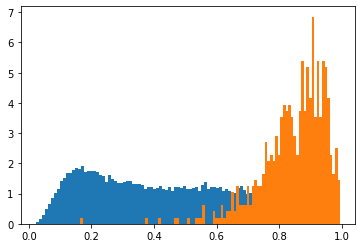

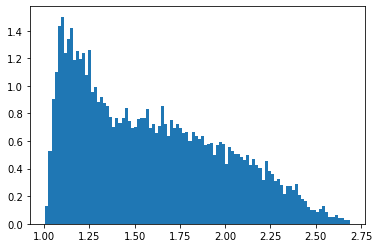

In [96]:
val1_MODEL = 'Colab SEED 18082020/Ensemble 384 + 512'
val2_MODEL = 'Seed 420/Ensemble 512 + 384'
val3_MODEL = 'Ensembles/B4+B5+B6+other'
val4_MODEL = 'Ensembles/Vatsal'
val5_MODEL = 'Ensembles/Vatsal/New Seed'
val6_MODEL = 'Ensembles/Bhautik'


print(val1_MODEL)
print(val2_MODEL)
print(val3_MODEL)
print(val4_MODEL)
print(val5_MODEL)
print(val6_MODEL)
print()


val1 = pd.read_csv([val1_MODEL+'/'+filename for filename in os.listdir(val1_MODEL) if "oofrank_" in filename][0])
val2 = pd.read_csv([val2_MODEL+'/'+filename for filename in os.listdir(val2_MODEL) if "oof_" in filename][0])
val3 = pd.read_csv([val3_MODEL+'/'+filename for filename in os.listdir(val3_MODEL) if "oofrank_0.9517" in filename][0])
val4 = pd.read_csv([val4_MODEL+'/'+filename for filename in os.listdir(val4_MODEL) if "oofrank_" in filename][0])
val5 = pd.read_csv([val5_MODEL+'/'+filename for filename in os.listdir(val5_MODEL) if "oofrank_" in filename][0])
val6 = pd.read_csv([val6_MODEL+'/'+filename for filename in os.listdir(val6_MODEL) if "oofrank_" in filename][0])

test1 = pd.read_csv([val1_MODEL+'/'+filename for filename in os.listdir(val1_MODEL) if "TESTPREDS_RANK" in filename][0])
test2 = pd.read_csv([val2_MODEL+'/'+filename for filename in os.listdir(val2_MODEL) if "TESTPREDS_MEAN" in filename][0])
test3 = pd.read_csv([val3_MODEL+'/'+filename for filename in os.listdir(val3_MODEL) if "TESTPREDS_RANK_0.9517" in filename][0])
test4 = pd.read_csv([val4_MODEL+'/'+filename for filename in os.listdir(val4_MODEL) if "TESTPREDS_RANK" in filename][0])
test5 = pd.read_csv([val5_MODEL+'/'+filename for filename in os.listdir(val5_MODEL) if "TESTPREDS_RANK" in filename][0])
test6 = pd.read_csv([val6_MODEL+'/'+filename for filename in os.listdir(val6_MODEL) if "TESTPREDS_RANK" in filename][0])


# weights = [0.9487946, 0.9437367, 0.9517729, 0.95007, 0.94704, 0.9322]

w0 = 0.58
w1 = 0.89
w2 = 0.85
w3 = 0.9998
w4 = 1.0

weights = [w4*w3*w2*(1-w1), w4*(1-w3), w4*w3*w2*w1*w0, w4*w3*w2*w1*(1-w0), w4*w3*(1-w2), (1-w4)]
weights /= np.sum(weights)
print(weights)
print("Sum of weights: ",np.sum(weights))

def getRanks(x):
    return rankdata(x)/rankdata(x).max()


valMerged = val1.merge(val2[['image_name','pred']],on='image_name',suffixes=('_1','_2'))\
    .merge(val3[['image_name','pred']],on='image_name',suffixes=('_2','_3'))\
    .merge(val4[['image_name','pred']],on='image_name',suffixes=('_3','_4'))\
    .merge(val5[['image_name','pred']],on='image_name',suffixes=('_4','_5'))\
    .merge(val6[['image_name','pred']],on='image_name',suffixes=('_5','_6'))


sub = pd.DataFrame()
sub['image_name'] = valMerged['image_name']
sub['target'] = np.exp(np.mean(
    [
        weights[0]*valMerged['pred_1'].apply(lambda x: np.log2(x)),
        weights[1]*valMerged['pred_2'].apply(lambda x: np.log2(x)),
        weights[2]*valMerged['pred_3'].apply(lambda x: np.log2(x)),
        weights[3]*valMerged['pred_4'].apply(lambda x: np.log2(x)),
        weights[4]*valMerged['pred_5'].apply(lambda x: np.log2(x)),
        weights[5]*valMerged['pred_6'].apply(lambda x: np.log2(x)),
    ], axis=0))

ranks = sub['target']


power = 1
sub = pd.DataFrame()
sub['image_name'] = valMerged['image_name']
sub['target'] = np.mean(
    [
        valMerged['pred_1'].apply(lambda x: x**power),
        valMerged['pred_2'].apply(lambda x: x**power),
        valMerged['pred_3'].apply(lambda x: x**power),
        valMerged['pred_4'].apply(lambda x: x**power),
        valMerged['pred_5'].apply(lambda x: x**power),
        valMerged['pred_6'].apply(lambda x: x**power),
    ], axis=0)

ranks = sub['target']

# print(valMerged.head())

# ranks = weights[0]*getRanks(valMerged.pred_1) + weights[1]*getRanks(valMerged.pred_2) + \
#     weights[2]*getRanks(valMerged.pred_3) + weights[3]*getRanks(valMerged.pred_4) + \
#     weights[4]*getRanks(valMerged.pred_5) + weights[5]*getRanks(valMerged.pred_6)

# ranks /= np.sum(weights)

means = weights[0]*valMerged.pred_1 + weights[1]*getRanks(valMerged.pred_2) + \
    weights[2]*valMerged.pred_3 + weights[3]*valMerged.pred_4 + \
    weights[4]*valMerged.pred_5 + weights[5]*valMerged.pred_6

# means /= np.sum(weights)

aucrank = roc_auc_score(valMerged.target,ranks)
print("Val AUC (RANK): ",aucrank)

aucmean = roc_auc_score(valMerged.target,means)
print("Val AUC (MEAN): ",aucmean)

if aucrank>best_rank_auc:
    best_rank_auc = aucrank
    best_rank_weights = weights
    
    print("\n\nIt is an Improvement in Rank-AUC!")
else:
    print("\n\nIt is NOT an Improvement in Rank-AUC!")
    print("Best RANK-AUC: ",best_rank_auc)
    print("Best RANK Weights: ",best_rank_weights)

    
if aucmean>best_mean_auc:
    best_mean_auc = aucmean
    best_mean_weights = weights
    
    print("\n\nIt is an Improvement in Mean-AUC!")

else:
    print("\n\nIt is NOT an Improvement in Mean-AUC!")
    print("Best MEAN-AUC: ",best_mean_auc)
    print("Best MEAN Weights: ",best_mean_weights)
    

# print()
# print(np.corrcoef(val2.pred,ranks))

# plt.hist(ranks[valMerged.target==0],bins=100)
# plt.hist(ranks[valMerged.target==1],bins=100)
# plt.show()

# metatest = pd.read_csv('../../../MetaDataOnly/2020-06-06_Test_LogisticRegression_0.684946489700843.csv')
# metaval = pd.read_csv('../../../MetaDataOnly/2020-06-06_Val_LogisticRegression_0.684946489700843.csv')

oofrank = pd.DataFrame(dict(
    image_name = valMerged.image_name,
    pred = ranks,
    target = valMerged.target
))

oof = pd.DataFrame(dict(
    image_name = valMerged.image_name,
    pred = means,
    target = valMerged.target
))

print(oofrank.shape)
print()

plt.hist(ranks[valMerged.target==0],bins=100,density=True)
plt.hist(ranks[valMerged.target==1],bins=100,density=True)
plt.show()


############################# TEST PREDS #########################################

sub = pd.DataFrame()
sub['image_name'] = test1['image_name']
sub['target'] = np.exp(np.mean(
    [
        test1.target.apply(lambda x: np.log2(x)),
        test2.target.apply(lambda x: np.log2(x)),
        test3.target.apply(lambda x: np.log2(x)),
        test4.target.apply(lambda x: np.log2(x)),
        test5.target.apply(lambda x: np.log2(x)),
        test6.target.apply(lambda x: np.log2(x)),  
    ], axis=0))

ranks = sub['target']


sub = pd.DataFrame()
sub['image_name'] = test1['image_name']
sub['target'] = np.mean(
    [
        test1.target.apply(lambda x: x**power),
        test2.target.apply(lambda x: x**power),
        test3.target.apply(lambda x: x**power),
        test4.target.apply(lambda x: x**power),
        test5.target.apply(lambda x: x**power),
        test6.target.apply(lambda x: x**power),  
    ], axis=0)

ranks = sub['target']

# ranks = weights[0]*getRanks(test1.target) + weights[1]*getRanks(test2.target) +\
#     weights[2]*getRanks(test3.target) + weights[3]*getRanks(test4.target) +\
#     weights[4]*getRanks(test5.target) + weights[5]*getRanks(test6.target)

# ranks /= np.sum(weights)

# ranks = weights[0]*getRanks(test1.target) + weights[1]*getRanks(test2.target) +\
#     weights[2]*getRanks(test3.target) + weights[3]*test4.target

# ranks = weights[0]*test1.target + weights[1]*test2.target +\
#     weights[2]*test3.target + weights[3]*test4.target


# means = weights[0]*test1.target + weights[1]*test2.target +\
#     weights[2]*test3.target + weights[3]*test4.target
means = weights[0]*test1.target + weights[1]*getRanks(test2.target) +\
    weights[2]*test3.target + weights[3]*test4.target +\
    weights[4]*test5.target + weights[5]*test6.target

# means /= np.sum(weights)

testrank = pd.DataFrame(dict(
    image_name = test1.image_name,
    target = ranks
))

testmean = pd.DataFrame(dict(
    image_name = test1.image_name,
    target = means
))

plt.hist(ranks,bins=100,density=True)

dirName = 'Ensembles/Final Ensembles'
# dirName = 'Colab SEED 18082020/Ensemble 384 + 512'

# oofrank.to_csv(f'{dirName}/oofrank_{aucrank}.csv',index=False)
# testrank.to_csv(f'{dirName}/TESTPREDS_RANK_{aucrank}.csv',index=False)

# oof.to_csv(f'{dirName}/oofrank_{aucmean}.csv',index=False)
# testmean.to_csv(f'{dirName}/TESTPREDS_RANK_{aucmean}.csv',index=False)

In [7]:
val1_MODEL = '../Colab SEED 18082020/Ensemble 384 + 512'
val2_MODEL = '../Seed 420/Ensemble 512 + 384'
val3_MODEL = '../Ensembles/B4+B5+B6+other'
val4_MODEL = '../Ensembles/Vatsal'
val5_MODEL = '../Ensembles/Vatsal/New Seed'
val6_MODEL = '../Ensembles/Bhautik'

print(val1_MODEL)
print(val2_MODEL)
print(val3_MODEL)
print(val4_MODEL)
print(val5_MODEL)
print(val6_MODEL)
print()


val1 = pd.read_csv([val1_MODEL+'/'+filename for filename in os.listdir(val1_MODEL) if "oofrank_" in filename][0])
val2 = pd.read_csv([val2_MODEL+'/'+filename for filename in os.listdir(val2_MODEL) if "oof_" in filename][0])
val3 = pd.read_csv([val3_MODEL+'/'+filename for filename in os.listdir(val3_MODEL) if "oofrank_0.9517" in filename][0])
val4 = pd.read_csv([val4_MODEL+'/'+filename for filename in os.listdir(val4_MODEL) if "oofrank_" in filename][0])
val5 = pd.read_csv([val5_MODEL+'/'+filename for filename in os.listdir(val5_MODEL) if "oofrank_" in filename][0])
val6 = pd.read_csv([val6_MODEL+'/'+filename for filename in os.listdir(val6_MODEL) if "oofrank_" in filename][0])

test1 = pd.read_csv([val1_MODEL+'/'+filename for filename in os.listdir(val1_MODEL) if "TESTPREDS_RANK" in filename][0])
test2 = pd.read_csv([val2_MODEL+'/'+filename for filename in os.listdir(val2_MODEL) if "TESTPREDS_MEAN" in filename][0])
test3 = pd.read_csv([val3_MODEL+'/'+filename for filename in os.listdir(val3_MODEL) if "TESTPREDS_RANK_0.9517" in filename][0])
test4 = pd.read_csv([val4_MODEL+'/'+filename for filename in os.listdir(val4_MODEL) if "TESTPREDS_RANK" in filename][0])
test5 = pd.read_csv([val5_MODEL+'/'+filename for filename in os.listdir(val5_MODEL) if "TESTPREDS_RANK" in filename][0])
test6 = pd.read_csv([val6_MODEL+'/'+filename for filename in os.listdir(val6_MODEL) if "TESTPREDS_RANK" in filename][0])

valMerged = val1[['image_name','pred']].merge(val2[['image_name','pred']],on='image_name',suffixes=('_1','_2'))\
    .merge(val3[['image_name','pred']],on='image_name',suffixes=('_2','_3'))\
    .merge(val4[['image_name','pred']],on='image_name',suffixes=('_3','_4'))\
    .merge(val5[['image_name','pred']],on='image_name',suffixes=('_4','_5'))\
    .merge(val6[['image_name','pred']],on='image_name',suffixes=('_5','_6'))

valMerged.head()

../Colab SEED 18082020/Ensemble 384 + 512
../Seed 420/Ensemble 512 + 384
../Ensembles/B4+B5+B6+other
../Ensembles/Vatsal
../Ensembles/Vatsal/New Seed
../Ensembles/Bhautik



,image_name,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6
0,ISIC_0052212,0.196309,0.014284,0.191025,0.391115,0.057988,0.167212
1,ISIC_0080817,0.882696,0.189913,0.874424,0.843217,0.770537,0.812890
2,ISIC_0080512,0.165721,0.009689,0.103429,0.391370,0.145995,0.394959
3,ISIC_0078712,0.735265,0.114964,0.704611,0.700642,0.703762,0.350422
4,ISIC_0086349,0.591158,0.044780,0.570354,0.483870,0.516813,0.419047


In [8]:
testMerged = test1.merge(test2,on='image_name',suffixes=('_1','_2'))\
    .merge(test3,on='image_name',suffixes=('_2','_3'))\
    .merge(test4,on='image_name',suffixes=('_3','_4'))\
    .merge(test5,on='image_name',suffixes=('_4','_5'))\
    .merge(test6,on='image_name',suffixes=('_5','_6'))

testMerged.head()

,image_name,target_1,target_2,target_3,target_4,target_5,target_6
0,ISIC_0052060,0.176193,0.007751,0.171702,0.243763,0.197932,0.333227
1,ISIC_0052349,0.169651,0.006849,0.125155,0.127541,0.236472,0.197869
2,ISIC_0058510,0.105116,0.004922,0.118434,0.055935,0.060544,0.177336
3,ISIC_0073313,0.143915,0.008863,0.189443,0.196783,0.183630,0.021034
4,ISIC_0073502,0.556200,0.052100,0.529352,0.521823,0.626869,0.432754


In [11]:
# valMerged.to_csv('Base Data/Ensemble_oof_base.csv',index=False)
# testMerged.to_csv('Base Data/Ensemble_test_base.csv',index=False)

In [111]:
filenames = sorted(os.listdir('./StackingSubmissions'))
filenames

['Ensembles',
 'PROBABILITY_CALIB_0.9504375179662671.csv',
 'TESTPREDS_STACKING_0.9328905419566841.csv',
 'TESTPREDS_STACKING_0.9337806879117836.csv',
 'TESTPREDS_STACKING_0.9445845952489137.csv',
 'TESTPREDS_STACKING_0.9481714165863238.csv',
 'TESTPREDS_STACKING_0.9502084019979963.csv',
 'TESTPREDS_STACKING_0.9519442857716385.csv',
 'TESTPREDS_STACKING_0.9533037053966901.csv',
 'oof_stacking_0.9328905419566841.csv',
 'oof_stacking_0.9337806879117836.csv',
 'oof_stacking_0.9445845952489137.csv',
 'oof_stacking_0.9481714165863238.csv',
 'oof_stacking_0.9502084019979963.csv',
 'oof_stacking_0.9519442857716385.csv',
 'oof_stacking_0.9533037053966901.csv']

In [115]:
oofs = []
testpreds = []
for filename in filenames:
    if 'oof' in filename:
        oofs.append(pd.read_csv('StackingSubmissions/' + filename))
    if 'TESTPREDS' in filename:
        testpreds.append(pd.read_csv('StackingSubmissions/' + filename))

valMerged = oofs[0]
testMerged = testpreds[0]

for i,df in enumerate(zip(oofs[1:],testpreds[1:])):
    oof, testmean = df
    
    valMerged = valMerged.merge(oof[['image_name','pred']],on='image_name',suffixes=(f'_{i}',f'_{i+1}'))
    testMerged = testMerged.merge(testmean,on='image_name',suffixes=(f'_{i}',f'_{i+1}'))
    
valMerged.head()

,image_name,pred_0,target,pred_1,pred_2,pred_3,pred_4,pred_5,pred
0,ISIC_0074311,0.002196,0,0.0,2.252272e-06,0.000058,0.001289,1.536699e-05,0.000275
1,ISIC_0076262,0.002198,0,0.0,4.990122e-05,0.000015,0.000887,1.510332e-04,0.001214
2,ISIC_0081956,0.002195,0,0.0,5.195436e-09,0.000057,0.001187,8.338523e-08,0.000246
3,ISIC_0082543,0.002195,0,0.0,4.143379e-07,0.000012,0.000932,3.524480e-06,0.000369
4,ISIC_0084270,0.002206,0,0.0,4.105418e-03,0.000487,0.001444,9.094040e-04,0.004546


In [116]:
testMerged.head()

,image_name,target_0,target_1,target_2,target_3,target_4,target_5,target
0,ISIC_0052060,0.001992,0.0,2.300869e-07,0.000082,0.000985,3.283086e-07,0.000139
1,ISIC_0052349,0.001992,0.0,1.689021e-08,0.000030,0.001004,1.424729e-07,0.000102
2,ISIC_0058510,0.001992,0.0,1.929668e-09,0.000031,0.000820,4.830541e-08,0.000110
3,ISIC_0073313,0.001992,0.0,2.318762e-08,0.000021,0.000850,3.547165e-07,0.000105
4,ISIC_0073502,0.001995,0.0,4.036712e-04,0.000297,0.001122,1.354682e-04,0.000250


In [117]:
valTarget = valMerged['target']
valMerged = valMerged.drop(['target'],axis=1)

In [118]:
valMerged.columns = ['image_name'] + [f'pred_{i}' for i in range(len(oofs))]
testMerged.columns = valMerged.columns

[0.001372 0.002548 0.00728  0.0208   0.048    0.32     0.6     ]
Sum of weights:  1.0
AUC RANK:  0.9552013827251865
AUC MEAN:  0.9547009670789647


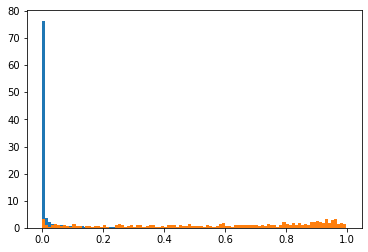

     image_name        target
0  ISIC_0052060  8.928271e-09
1  ISIC_0052349  1.945063e-08
2  ISIC_0058510  2.531684e-11
3  ISIC_0073313  2.638520e-11
4  ISIC_0073502  5.488851e-05


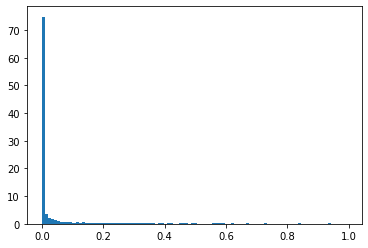

In [141]:
w0 = 0.35
w1 = 0.35
w2 = 0.35
w3 = 0.4
w4 = 0.2
w5 = 0.4

weights = [(1-w5),w5*(1-w4),w5*w4*(1-w3),w6*w5*w4*w3*(1-w2),w6*w5*w4*w3*w2*(1-w1),w6*w5*w4*w3*w2*w1*(1-w0),w6*w5*w4*w3*w2*w1*w0]
weights = weights[::-1]
weights /= np.sum(weights)
print(weights)
print("Sum of weights: ",np.sum(weights))

def getRanks(x):
    return rankdata(x)/rankdata(x).max()

ranks = 0
means = 0
for i in range(len(oofs)):
    ranks += weights[i]*getRanks(valMerged[f'pred_{i}'])
    means += weights[i]*valMerged[f'pred_{i}']
    

power = 16
ranks = 0
for i in range(len(oofs)):
    ranks += weights[i]*(pd.Series(getRanks(valMerged[f'pred_{i}'])).apply(lambda x: x**power))
    
# ranks = 0
# for i in range(len(oofs)):
#     ranks += weights[i]*(pd.Series(valMerged[f'pred_{i}']).apply(lambda x: np.log2(x)))
# ranks = np.exp(ranks)

aucrank = roc_auc_score(valTarget,ranks)
aucmean = roc_auc_score(valTarget,means)
print("AUC RANK: ",aucrank)
print("AUC MEAN: ",aucmean)

oofrank = pd.DataFrame(dict(
    image_name = valMerged.image_name,
    pred = ranks,
    target = valTarget
))

oof = pd.DataFrame(dict(
    image_name = valMerged.image_name,
    pred = means,
    target = valTarget
))

plt.hist(ranks[valTarget==0],bins=100,density=True)
plt.hist(ranks[valTarget==1],bins=100,density=True)
plt.show()

##################################################################################################################

ranks = 0
means = 0
for i in range(len(oofs)):
    ranks += weights[i]*getRanks(testMerged[f'pred_{i}'])
    means += weights[i]*testMerged[f'pred_{i}']

ranks = 0
for i in range(len(oofs)):
    ranks += weights[i]*(pd.Series(getRanks(testMerged[f'pred_{i}'])).apply(lambda x: x**power))
    
# ranks = 0
# for i in range(len(oofs)):
#     ranks += weights[i]*(pd.Series(testMerged[f'pred_{i}']).apply(lambda x: np.log2(x)))
# ranks = np.exp(ranks)


testrank = pd.DataFrame(dict(
    image_name = testMerged.image_name,
    target = ranks
))

testmean = pd.DataFrame(dict(
    image_name = testMerged.image_name,
    target = means
))

plt.hist(ranks,bins=100,density=True)

print(testrank.head())

# dirName = 'StackingSubmissions/Ensembles'

# oofrank.to_csv(f'{dirName}/oofrank_stacking_{aucrank}.csv',index=False)
# testrank.to_csv(f'{dirName}/TESTPREDS_RANK_STACKING_{aucrank}.csv',index=False)

# oof.to_csv(f'{dirName}/oofmean_stacking_{aucmean}.csv',index=False)
# testmean.to_csv(f'{dirName}/TESTPREDS_MEAN_STACKING_{aucmean}.csv',index=False)

## Ensembling with Public Model

In [143]:
public_sub = pd.read_csv('StackingSubmissions/Public/submission.csv')
public_sub.head()

,image_name,target
0,ISIC_0052060,0.019489
1,ISIC_0052349,0.015591
2,ISIC_0058510,0.022990
3,ISIC_0073313,0.017380
4,ISIC_0073502,0.015104


In [144]:
our_sub = pd.read_csv('StackingSubmissions/Ensembles/TESTPREDS_RANK_STACKING_0.9552013827251865.csv')
our_sub.head()

,image_name,target
0,ISIC_0052060,8.928271e-09
1,ISIC_0052349,1.945063e-08
2,ISIC_0058510,2.531684e-11
3,ISIC_0073313,2.638520e-11
4,ISIC_0073502,5.488851e-05


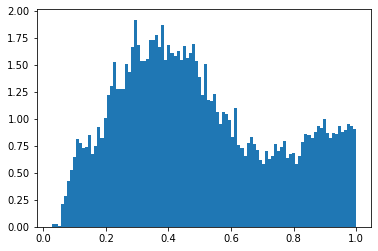

In [151]:
weight = 0.5
target = weight*getRanks(public_sub.target) + (1-weight)*getRanks(our_sub.target)

plt.hist(target,bins=100,density=True)
plt.show()

In [152]:
# our_sub['target'] = target
# our_sub.to_csv('StackingSubmissions/Ensembles/Public/Public_OurBest_0.9552013827251865.csv',index=False)

### Stacking -> Ensembles SEED 2020

In [274]:
PATH = 'StackingSubmissions/Seed2020/'

Extra = sorted(['StackingSubmissions/Ensembles/TESTPREDS_RANK_STACKING_0.9552013827251865.csv',
        'StackingSubmissions/Ensembles/oofrank_stacking_0.9552013827251865.csv'])

filenames = sorted(os.listdir(PATH))

filenames,Extra

(['TESTPREDS_STACKING_0.9364423352708717.csv',
  'TESTPREDS_STACKING_0.9449570929495799.csv',
  'TESTPREDS_STACKING_0.9484620660980673.csv',
  'TESTPREDS_STACKING_0.9492177012279535.csv',
  'TESTPREDS_STACKING_0.9525588707973004.csv',
  'oof_stacking_0.9364423352708717.csv',
  'oof_stacking_0.9449570929495799.csv',
  'oof_stacking_0.9484620660980673.csv',
  'oof_stacking_0.9492177012279535.csv',
  'oof_stacking_0.9525588707973004.csv'],
 ['StackingSubmissions/Ensembles/TESTPREDS_RANK_STACKING_0.9552013827251865.csv',
  'StackingSubmissions/Ensembles/oofrank_stacking_0.9552013827251865.csv'])

In [156]:
oofs = []
testpreds = []

for filename in filenames:
    if 'oof' in filename:
        oofs.append(pd.read_csv(PATH + filename))
    if 'TESTPREDS' in filename:
        testpreds.append(pd.read_csv(PATH + filename))

for filename in Extra:
    if 'oof' in filename:
        oofs.append(pd.read_csv(filename))
    if 'TESTPREDS' in filename:
        testpreds.append(pd.read_csv(filename))

valMerged = oofs[0]
testMerged = testpreds[0]

for i,df in enumerate(zip(oofs[1:],testpreds[1:])):
    oof, testmean = df
    
    valMerged = valMerged.merge(oof[['image_name','pred']],on='image_name',suffixes=(f'_{i}',f'_{i+1}'))
    testMerged = testMerged.merge(testmean,on='image_name',suffixes=(f'_{i}',f'_{i+1}'))
    
valMerged.head()

,image_name,pred_0,target,pred_1,pred_2,pred_3,pred_4,pred_5
0,ISIC_0074311,0.0,0,7.865490e-41,0.001381,0.000050,0.000233,0.000009
1,ISIC_0076262,0.0,0,5.892881e-37,0.001381,0.000179,0.001088,0.000050
2,ISIC_0081956,0.0,0,3.852927e-42,0.001381,0.000064,0.000285,0.000002
3,ISIC_0082543,0.0,0,2.599471e-41,0.001381,0.000130,0.000307,0.000003
4,ISIC_0084270,0.0,0,2.373830e-30,0.002717,0.000366,0.004359,0.001829


In [157]:
valTarget = valMerged['target']
valMerged = valMerged.drop(['target'],axis=1)

valMerged.columns = ['image_name'] + [f'pred_{i}' for i in range(len(oofs))]
testMerged.columns = valMerged.columns

testMerged.head()

,image_name,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5
0,ISIC_0052060,0.0,1.609360e-40,0.001148,0.000048,0.000106,8.928271e-09
1,ISIC_0052349,0.0,9.065071e-42,0.001148,0.000058,0.000096,1.945063e-08
2,ISIC_0058510,0.0,1.504177e-42,0.001148,0.000058,0.000115,2.531684e-11
3,ISIC_0073313,0.0,1.793146e-42,0.001148,0.000061,0.000107,2.638520e-11
4,ISIC_0073502,0.0,5.349357e-36,0.001148,0.000115,0.000233,5.488851e-05


[3.920e-06 1.176e-05 2.352e-05 4.080e-05 1.200e-04 9.998e-01 0.000e+00]
Sum of weights:  1.0

Power:  2
AUC RANK:  0.9552014899264818
AUC MEAN:  0.9551591454148587


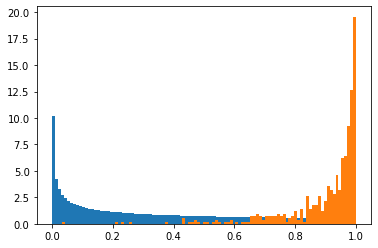

     image_name    target
0  ISIC_0052060  0.028622
1  ISIC_0052349  0.035525
2  ISIC_0058510  0.000536
3  ISIC_0073313  0.002308
4  ISIC_0073502  0.267022


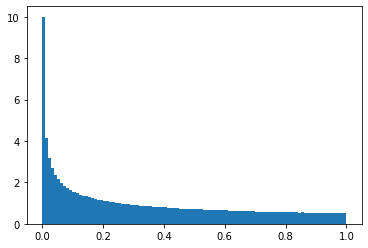

In [273]:
w0 = 0.25
w1 = 0.4
w2 = 0.49
w3 = 0.4
w4 = 0.0002
w5 = 1.0

# w0 = 0.45
# w1 = 0.48
# w2 = 0.52
# w3 = 0.3
# w4 = 1.0
# w5 = 1.0

weights = [(1-w5),w5*(1-w4),w5*w4*(1-w3),w6*w5*w4*w3*(1-w2),w6*w5*w4*w3*w2*(1-w1),w6*w5*w4*w3*w2*w1*(1-w0),w6*w5*w4*w3*w2*w1*w0]
weights = weights[::-1]
weights /= np.sum(weights)
print(weights)
print("Sum of weights: ",np.sum(weights))

def getRanks(x):
    return rankdata(x)/rankdata(x).max()

ranks = 0
means = 0
for i in range(len(oofs)):
    ranks += weights[i]*getRanks(valMerged[f'pred_{i}'])
    means += weights[i]*valMerged[f'pred_{i}']
    

power = 2
print("\nPower: ",power)
ranks = 0
for i in range(len(oofs)):
    ranks += weights[i]*(pd.Series(getRanks(valMerged[f'pred_{i}'])).apply(lambda x: x**power))
    
# ranks = 0
# for i in range(len(oofs)):
#     ranks += weights[i]*(pd.Series(valMerged[f'pred_{i}']).apply(lambda x: np.log2(x)))
# ranks = np.exp(ranks)

aucrank = roc_auc_score(valTarget,ranks)
aucmean = roc_auc_score(valTarget,means)
print("AUC RANK: ",aucrank)
print("AUC MEAN: ",aucmean)

oofrank = pd.DataFrame(dict(
    image_name = valMerged.image_name,
    pred = ranks,
    target = valTarget
))

oof = pd.DataFrame(dict(
    image_name = valMerged.image_name,
    pred = means,
    target = valTarget
))

plt.hist(ranks[valTarget==0],bins=100,density=True)
plt.hist(ranks[valTarget==1],bins=100,density=True)
plt.show()

##################################################################################################################

ranks = 0
means = 0
for i in range(len(oofs)):
    ranks += weights[i]*getRanks(testMerged[f'pred_{i}'])
    means += weights[i]*testMerged[f'pred_{i}']

ranks = 0
for i in range(len(oofs)):
    ranks += weights[i]*(pd.Series(getRanks(testMerged[f'pred_{i}'])).apply(lambda x: x**power))
    
# ranks = 0
# for i in range(len(oofs)):
#     ranks += weights[i]*(pd.Series(testMerged[f'pred_{i}']).apply(lambda x: np.log2(x)))
# ranks = np.exp(ranks)


testrank = pd.DataFrame(dict(
    image_name = testMerged.image_name,
    target = ranks
))

testmean = pd.DataFrame(dict(
    image_name = testMerged.image_name,
    target = means
))

plt.hist(ranks,bins=100,density=True)

print(testrank.head())

# dirName = 'StackingSubmissions/Ensembles'

# oofrank.to_csv(f'{dirName}/oofrank_stacking_{aucrank}.csv',index=False)
# testrank.to_csv(f'{dirName}/TESTPREDS_RANK_STACKING_{aucrank}.csv',index=False)

# oof.to_csv(f'{dirName}/oofmean_stacking_{aucmean}.csv',index=False)
# testmean.to_csv(f'{dirName}/TESTPREDS_MEAN_STACKING_{aucmean}.csv',index=False)

# 0.9552014899264818

### BestCV + VP

In [280]:
os.listdir('StackingSubmissions/Ensembles')

['oofmean_stacking_0.9547009670789647.csv',
 'oofmean_stacking_0.9551591454148587.csv',
 'oofrank_stacking_0.9545611765899601.csv',
 'oofrank_stacking_0.9552013827251865.csv',
 'oofrank_stacking_0.9552014899264818.csv',
 'Public',
 'TESTPREDS_MEAN_STACKING_0.9547009670789647.csv',
 'TESTPREDS_MEAN_STACKING_0.9551591454148587.csv',
 'TESTPREDS_RANK_STACKING_0.9545611765899601.csv',
 'TESTPREDS_RANK_STACKING_0.9552013827251865.csv',
 'TESTPREDS_RANK_STACKING_0.9552014899264818.csv']

Weights:  [0.54, 0.45999999999999996]

Power:  8
AUC RANK:  0.9556103556665613
AUC MEAN:  0.9555354755618299


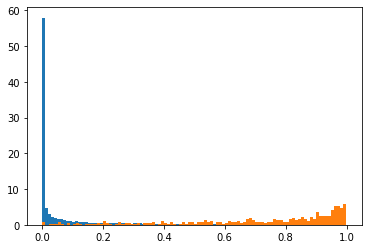

     image_name    target
0  ISIC_0052060  0.000526
1  ISIC_0052349  0.000001
2  ISIC_0058510  0.000005
3  ISIC_0073313  0.000002
4  ISIC_0073502  0.006592


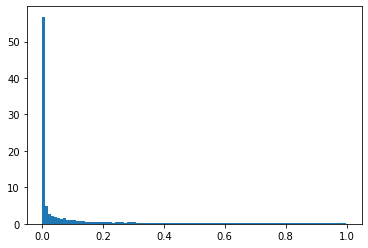

In [303]:
oof1 = pd.read_csv('StackingSubmissions/Ensembles/oofrank_stacking_0.9552014899264818.csv')
oof2 = pd.read_csv('StackingSubmissions/Vatsal/oof_rank_0.95489.csv')

test1 = pd.read_csv('StackingSubmissions/Ensembles/TESTPREDS_RANK_STACKING_0.9552014899264818.csv')
test2 = pd.read_csv('StackingSubmissions/Vatsal/submission_rank.csv')

valMerged = oof1.merge(oof2[['image_name','pred']],on='image_name',suffixes=('_0','_1'))
valTarget = valMerged.target

testMerged = test1.merge(test2,on='image_name',suffixes=('_0','_1'))

w0 = 0.54
weights = [w0, (1-w0)]
print("Weights: ",weights)

ranks = 0
means = 0
for i in range(2):
    ranks += weights[i]*getRanks(valMerged[f'pred_{i}'])
    means += weights[i]*valMerged[f'pred_{i}']
    

power = 8
print("\nPower: ",power)
ranks = 0
for i in range(2):
    ranks += weights[i]*(pd.Series(getRanks(valMerged[f'pred_{i}'])).apply(lambda x: x**power))
    
# ranks = 0
# for i in range(len(oofs)):
#     ranks += weights[i]*(pd.Series(valMerged[f'pred_{i}']).apply(lambda x: np.log2(x)))
# ranks = np.exp(ranks)

aucrank = roc_auc_score(valTarget,ranks)
aucmean = roc_auc_score(valTarget,means)
print("AUC RANK: ",aucrank)
print("AUC MEAN: ",aucmean)

oofrank = pd.DataFrame(dict(
    image_name = valMerged.image_name,
    pred = ranks,
    target = valTarget
))

oof = pd.DataFrame(dict(
    image_name = valMerged.image_name,
    pred = means,
    target = valTarget
))

plt.hist(ranks[valTarget==0],bins=100,density=True)
plt.hist(ranks[valTarget==1],bins=100,density=True)
plt.show()

##################################################################################################################

ranks = 0
means = 0
for i in range(2):
    ranks += weights[i]*getRanks(testMerged[f'target_{i}'])
    means += weights[i]*testMerged[f'target_{i}']

ranks = 0
for i in range(2):
    ranks += weights[i]*(pd.Series(getRanks(testMerged[f'target_{i}'])).apply(lambda x: x**power))
    
# ranks = 0
# for i in range(len(oofs)):
#     ranks += weights[i]*(pd.Series(testMerged[f'pred_{i}']).apply(lambda x: np.log2(x)))
# ranks = np.exp(ranks)


testrank = pd.DataFrame(dict(
    image_name = testMerged.image_name,
    target = ranks
))

testmean = pd.DataFrame(dict(
    image_name = testMerged.image_name,
    target = means
))

plt.hist(ranks,bins=100,density=True)

print(testrank.head())

# dirName = 'StackingSubmissions/Ensembles'

# oofrank.to_csv(f'{dirName}/oofrank_stacking_{aucrank}.csv',index=False)
# testrank.to_csv(f'{dirName}/TESTPREDS_RANK_STACKING_{aucrank}.csv',index=False)

# oof.to_csv(f'{dirName}/oofmean_stacking_{aucmean}.csv',index=False)
# testmean.to_csv(f'{dirName}/TESTPREDS_MEAN_STACKING_{aucmean}.csv',index=False)